In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import squidpy as sq
from sklearn.metrics.pairwise import cosine_similarity
import statistics
import pandas as pd
import json
import pickle
from anndata import AnnData
import pathlib
import skimage
import seaborn as sns
import tangram as tg
from scipy.spatial import distance

/home/apon/anaconda3/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load data
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

# Load cell-type distributions

### EM approach

In [3]:
class EM_postprocess:
    
    def __init__(self, candidates, adata_sc, adata_st, n_cells_spot, spatial_coords, max_iter, alpha, beta):
        
        self.S = {} #Contains indices of best fitting cells per voxel (index_voxel: [index_cells])
        self.candidates = candidates
        self.adata_sc = adata_sc
        self.adata_st = adata_st
        self.n_cells_spot = n_cells_spot
        self.spatial_coords = spatial_coords
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        
        self.n_voxels = self.adata_st.shape[0]
        
        shared_genes = adata_sc.var_names.intersection(adata_st.var_names, sort=False)
        self.adata_sc_shared_genes = adata_sc[:, adata_sc.var_names.isin(shared_genes)].copy()
        self.adata_st_shared_genes = adata_st[:, adata_st.var_names.isin(shared_genes)].copy()
        
    def _init_candidates(self, v):
        """
        input: one-hot encoded vector
        output: np.array (len <= n_cells_spot) with indices of the selected cells to represent the spot at init
        if n_cells_spot > candidates it returns all the candidates.
        """
        one_indices = np.where(v == 1)[0]
        
        if len(one_indices) >= self.n_cells_spot:
            selected = np.random.choice(one_indices, size=self.n_cells_spot, replace=False)
        else:
            selected = one_indices
    
        return selected
    
    def _get_candidates(self, v):
        """
        Input: one-hot encoded vector
        Output: np.array with the indices of the candidates of a voxel.
        """
        
        return np.where(v == 1)[0]
    
    def _get_neighbors(self, v, radius=300):
        """
        Given a voxel index and a radius, return indices of voxels within radius.
        Output: np.ndarray: Indices of neighboring voxels.
        """
        
        ref_coord = self.spatial_coords[v]

        # Compute Euclidean distances from the reference voxel to all others
        dists = np.linalg.norm(self.spatial_coords - ref_coord, axis=1)

        # Get indices of voxels within the radius (excluding the voxel itself)
        neighbor_indices = np.where((dists > 0) & (dists <= radius))[0]
        
        return neighbor_indices
    
    def _cosine_similarity(self, vec1, vec2):
        """
        Computes cosine similarity between two vectors.
        """
        vec1 = vec1.ravel()
        vec2 = vec2.ravel()
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def _neighbors_similarity(self, vec1, neighbors):
        """
        Vec1 is a vector.
        neighbors is an array containing the index of the neighboring voxels.
        
        This function averages the expression profile of ALL cells in neighboring voxels 
        and then performs cosine similarity between the resulting mean expression vector 
        and our candidate vector.
        """
        neighbor_cells = [cell for n in neighbors for cell in self.S[n]] #list with index of all currently chosen neighbor cells
        mean_neigh_expr = self.adata_sc.X[neighbor_cells].toarray().mean(axis=0)
        return self._cosine_similarity(vec1, mean_neigh_expr)
    
    def _compare_S(self, S, S_new):
        """
        Compares if previous selection of cells in all voxels are the same in the new iteration.
        Checks if two dictionaries are identical.
        """
        for key in S:
            if sorted(S[key]) != sorted(S_new[key]):
                return False

        return True
           
    def run_EM(self):
        self.logs = []  # List to store iteration logs

        #----- init -----
        for v in range(self.n_voxels):
            self.S[v] = self._init_candidates(self.candidates[:, v])

        #----- E-M steps -----
        for iteration in range(self.max_iter):
            S_new = {}
            used_cells = set()  # Track cells already assigned to prevent reuse
            voxel_order = np.random.permutation(self.n_voxels)  # Shuffle voxel update order

            for v in voxel_order:
                candidates = self._get_candidates(self.candidates[:, v])
                available_candidates = [c for c in candidates if c not in used_cells]

                # If no candidates available (all have been used), skip voxel
                if len(available_candidates) == 0:
                    S_new[v] = []
                    continue

                neighbors = self._get_neighbors(v)
                scores = []

                for c in available_candidates:
                    # E-step: Compute similarity scores
                    vec_c = self.adata_sc_shared_genes.X[c, :].toarray() #candidate expr pattern for sim_voxel
                    vec_cc = self.adata_sc.X[c, :].toarray() #candidate expr pattern for sim_neighbors

                    sim_voxel = self._cosine_similarity(vec_c, self.adata_st_shared_genes.X[v, :].toarray())
                    sim_neighbors = self._neighbors_similarity(vec_cc, neighbors)
                    score = self.alpha * sim_voxel + self.beta * sim_neighbors
                    scores.append(score)

                scores = np.array(scores)
                gamma = np.exp(scores - np.max(scores))  # Softmax normalization
                gamma /= gamma.sum()

                # M-step: Select top-n_cells_spot based on gamma (limited by availability)
                top_idx = np.argsort(gamma)[-min(self.n_cells_spot, len(available_candidates)):]
                selected = [available_candidates[i] for i in top_idx]

                S_new[v] = selected
                used_cells.update(selected)

            # Log progress
            self.logs.append({
                "iteration": iteration,
                "n_voxels_updated": sum(len(v) > 0 for v in S_new.values()),
                "n_cells_used": len(used_cells),
            })

            print(f"Iteration {iteration+1}: {len(used_cells)} cells assigned across {self.n_voxels} voxels.")

            # Check for convergence
            if self._compare_S(self.S, S_new):
                print(f"Converged at iteration {iteration+1}.")
                break

            self.S = S_new
    
    def assess_EM(self):
        """
        Computes the cos sim between the average expr of all cells in a voxel and the expr of the same voxel
        in spatial data.
        
        Computes the cos sim between the mean expr of all cells in a voxel and the mean expr of all neighbor voxels
        in spatial data.
        """
        self.result_vox_sim = []
        self.result_neigh_sim = []

        for v in self.S:
            #Cos sim between our selected cells mean expr and the voxel gene expr
            mean_gene_expr_v = self.adata_sc_shared_genes.X[self.S[v]].toarray().mean(axis=0) #mean gene expr of cells in voxel v
            self.result_vox_sim.append(self._cosine_similarity(mean_gene_expr_v, self.adata_st_shared_genes.X[v, :].toarray()))
            
            #Cos sim between our selected cells mean expr and neighboring voxels
            neighbors = self._get_neighbors(v)
            mean_gene_expr_v = self.adata_sc.X[self.S[v]].toarray().mean(axis=0)
            self.result_neigh_sim.append(self._neighbors_similarity(mean_gene_expr_v, neighbors))
        
        print("Find results in self.result_vox_sim and self.result_neigh_sim")
        

In [4]:
# Load pickle file containing instance of class EM_postprocess with results noted.

with open("../EM_approach/results/em_300_object.pkl", "rb") as f:
    em_post_obj = pickle.load(f)

In [9]:
#forgot to run self.assess_EM
em_post_obj.assess_EM()

Find results in self.result_vox_sim and self.result_neigh_sim


In [12]:
#em_post_obj.S
#em_post_obj.result_vox_sim
em_post_obj.result_neigh_sim

[0.9957772,
 0.9942964,
 0.99537915,
 0.9961059,
 0.9947401,
 0.9921045,
 0.9945728,
 0.9938201,
 0.99645174,
 0.9948576,
 0.9927594,
 0.99416006,
 0.99070597,
 0.9927413,
 0.9934178,
 0.9957584,
 0.99576265,
 0.9960574,
 0.99670124,
 0.9944157,
 0.99504244,
 0.99637395,
 0.99611455,
 0.99465084,
 0.99498945,
 0.993566,
 0.9900765,
 0.9950392,
 0.9965208,
 0.9912878,
 0.994694,
 0.99525106,
 0.99643356,
 0.9919759,
 0.9936734,
 0.9941332,
 0.99461097,
 0.9961625,
 0.99672717,
 0.9950426,
 0.99619293,
 0.9965021,
 0.99575925,
 0.993705,
 0.99613225,
 0.995638,
 0.99574655,
 0.9957445,
 0.9959079,
 0.996289,
 0.9950737,
 0.99198925,
 0.9963236,
 0.9955674,
 0.9945693,
 0.9954743,
 0.99449545,
 0.99476534,
 0.99629134,
 0.99187374,
 0.9965628,
 0.9934432,
 0.9962945,
 0.9956329,
 0.9945858,
 0.99574775,
 0.9950439,
 0.9945566,
 0.9943058,
 0.99602664,
 0.9954613,
 0.9965594,
 0.99461675,
 0.9953308,
 0.9955458,
 0.995846,
 0.99624264,
 0.9957248,
 0.9948697,
 0.99634963,
 0.99591815,
 0.9

In [13]:
def compute_ct_dist_from_dict(dic, adata_sc):
    
    cell_types = adata_sc.obs["cell_subclass"]
    unique_types = cell_types.unique()
    
    n_voxels = len(dic)
    n_types = len(unique_types)

    # Map cell type to row index
    type_to_index = {ctype: i for i, ctype in enumerate(unique_types)}
    
    # Initialize result matrix
    result = np.zeros((n_types, n_voxels), dtype=float)
    
    for v in range(n_voxels):
        cell_indices = dic.get(v, [])
        if len(cell_indices) == 0:
            continue
        # Get types of selected cells
        types = cell_types.iloc[cell_indices]
        counts = types.value_counts()
        
        for ctype, count in counts.items():
            row = type_to_index[ctype]
            result[row, v] = count
        
        # Normalize to sum to 1 (convert counts to probabilities)
        total = result[:, v].sum()
        if total > 0:
            result[:, v] /= total

    return result, unique_types  # also return unique_types to map rows back to cell types


In [ ]:
em_ct, ct_to_idx = compute_ct_dist_from_dict(em_post_obj.S, adata_sc):

### C2L

In [8]:
cell2loc_results = sc.read_h5ad("../ct_dist_tg_vs_c2loc/results/cell2location_map/sp.h5ad") #read cell2loc results

In [17]:
cell2loc_results.obsm["means_cell_abundance_w_sf"]

,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Astro,meanscell_abundance_w_sf_means_per_cluster_mu_fg_CR,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Endo,meanscell_abundance_w_sf_means_per_cluster_mu_fg_L2/3 IT,meanscell_abundance_w_sf_means_per_cluster_mu_fg_L4,meanscell_abundance_w_sf_means_per_cluster_mu_fg_L5 IT,meanscell_abundance_w_sf_means_per_cluster_mu_fg_L5 PT,meanscell_abundance_w_sf_means_per_cluster_mu_fg_L6 CT,meanscell_abundance_w_sf_means_per_cluster_mu_fg_L6 IT,meanscell_abundance_w_sf_means_per_cluster_mu_fg_L6b,...,meanscell_abundance_w_sf_means_per_cluster_mu_fg_NP,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Oligo,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Peri,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Pvalb,meanscell_abundance_w_sf_means_per_cluster_mu_fg_SMC,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Serpinf1,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Sncg,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Sst,meanscell_abundance_w_sf_means_per_cluster_mu_fg_VLMC,meanscell_abundance_w_sf_means_per_cluster_mu_fg_Vip
AAATGGCATGTCTTGT-1,1.823807,4.823495,0.510032,0.147920,0.343678,0.705217,2.244010,3.454170,4.411379,0.554617,...,0.331142,0.852914,0.179797,0.886666,0.302574,0.377684,0.391636,0.520359,0.052804,0.194324
AACAACTGGTAGTTGC-1,1.999075,5.179205,0.392400,0.582221,0.703166,2.993276,5.637232,1.882915,2.737726,0.434717,...,1.207915,1.424132,0.605751,1.404374,0.123073,0.348794,0.258067,0.121239,0.085825,0.136806
AACAGGAAATCGAATA-1,1.546857,7.984003,0.410367,0.198795,0.223705,0.125987,0.564693,10.692219,7.339805,1.062366,...,0.223165,1.531277,0.370453,0.502812,0.237952,0.436932,0.231542,0.167257,0.096506,0.265450
AACCCAGAGACGGAGA-1,2.134696,5.302188,0.583284,4.698818,2.029144,0.374674,0.273301,0.659056,0.490762,0.143423,...,0.109594,0.321747,0.233683,0.968668,0.147453,0.632688,0.246845,0.119339,0.578761,0.096515
AACCGTTGTGTTTGCT-1,1.262577,5.510438,1.796538,1.272152,1.224490,3.705018,3.652741,0.202080,0.422329,0.443443,...,0.513237,0.801762,0.238619,1.297155,0.246121,0.328377,0.196766,0.151371,0.052810,0.109555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGATTGGGTACCAC-1,2.517296,4.152444,0.497078,0.278103,1.373056,4.228068,5.376845,0.385406,0.591382,0.379483,...,0.820921,1.357290,0.491383,3.037873,0.333674,0.211449,0.209316,0.464098,0.210125,0.108335
TTGGCTCGCATGAGAC-1,1.717280,7.804150,0.558789,16.993872,4.469916,0.285311,0.263191,0.158127,0.200649,0.151799,...,0.103176,0.457320,0.236555,1.647563,0.130258,0.935603,0.489044,0.381685,0.109778,0.187665
TTGTATCACACAGAAT-1,0.663212,8.684666,0.534734,0.237911,0.180935,0.562327,2.988594,7.718921,9.417141,1.090759,...,0.868632,1.786388,0.383562,1.283136,0.198665,0.390527,0.213700,0.740241,0.127308,0.137619
TTGTGGCCCTGACAGT-1,1.644960,8.614881,1.140032,0.236096,0.209695,0.099152,0.226208,6.124181,6.071265,0.902891,...,0.105394,3.186229,0.215174,0.317548,0.282898,0.269712,0.151699,0.109896,0.121208,0.105175


In [9]:
cell2loc_matrix = cell2loc_results.obsm["means_cell_abundance_w_sf"] #get cell2location results

cell2loc_matrix = cell2loc_matrix.T  #transpose matrix so I can compare to tg

cell2loc_dist = cell2loc_matrix.div(cell2loc_matrix.sum(axis=0), axis=1) #normalize so each row sums up to 1


### TG

In [6]:
tg = np.load("results/TG.npy") #load tg results

In [10]:
tg.shape == cell2loc_dist.shape

True

In [12]:
print(tg)

[[0.06753609 0.06804352 0.06379537 ... 0.09505315 0.09517517 0.09517445]
 [0.0143473  0.00710844 0.00468808 ... 0.06107164 0.06101342 0.06175969]
 [0.10571534 0.1456712  0.12732612 ... 0.12187762 0.12196005 0.12190625]
 ...
 [0.00081998 0.00076131 0.00050467 ... 0.00078437 0.00078199 0.00078352]
 [0.00296962 0.0014708  0.00097019 ... 0.00605594 0.00605585 0.0060377 ]
 [0.00897459 0.00629672 0.00563738 ... 0.0048919  0.00489004 0.00488547]]


In [17]:
c2l = cell2loc_dist.values  # convert pandas DataFrame to NumPy

# Similarity per spot (column-wise comparison)
similarity = [
    cosine_similarity(tg[:, [i]].T, c2l[:, [i]].T)[0, 0]
    for i in range(tg.shape[1])
]

correlations = [
    np.corrcoef(tg[:, i], c2l[:, i])[0, 1]
    for i in range(tg.shape[1])
]

(array([ 1., 10., 26., 26., 52., 70., 51., 46., 38.,  4.]),
 array([0.24073649, 0.28610623, 0.33147596, 0.3768457 , 0.42221543,
        0.46758517, 0.5129549 , 0.55832464, 0.60369437, 0.64906411,
        0.69443384]),
 <BarContainer object of 10 artists>)

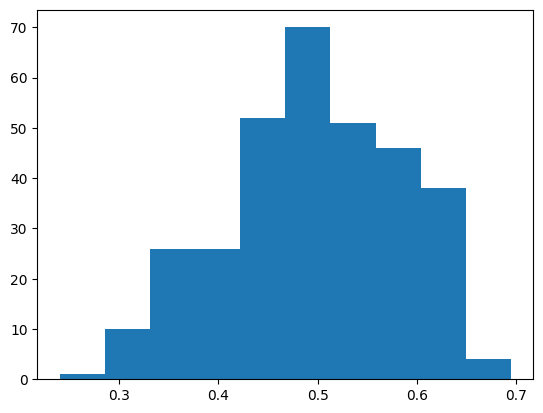

In [18]:
plt.hist(similarity)

(array([ 3.,  5., 19., 53., 72., 73., 42., 32., 23.,  2.]),
 array([-0.10853565, -0.05097835,  0.00657896,  0.06413626,  0.12169356,
         0.17925087,  0.23680817,  0.29436547,  0.35192278,  0.40948008,
         0.46703739]),
 <BarContainer object of 10 artists>)

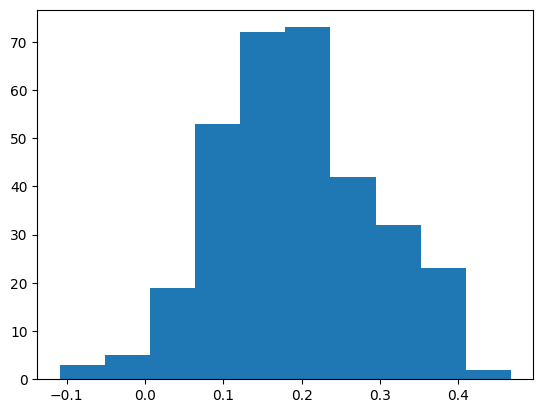

In [19]:
plt.hist(correlations)

/tmp/ipykernel_2507918/1883001416.py:5: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


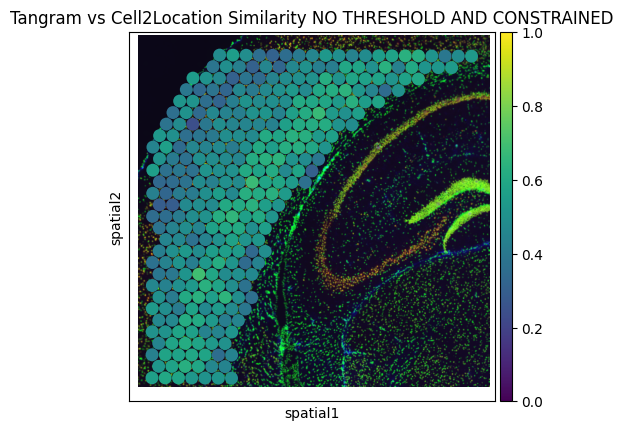

In [22]:
# Add similarity metric as a new column in .obs
cell2loc_results.obs['tg_vs_c2l_similarity'] = similarity  # or correlations

# Plot over tissue
sc.pl.spatial(
    cell2loc_results,
    color='tg_vs_c2l_similarity',
    cmap='viridis',
    size=1.5,
    title="Tangram vs Cell2Location Similarity NO THRESHOLD AND CONSTRAINED",
    vmin=0,
    vmax=1
)